In [1]:
%matplotlib inline
import os
os.environ['DATA_PATH'] = "/root/work/data"
import matplotlib.pyplot as plt
from invoke import task
from collections import OrderedDict
import numpy as np
from model import build_dense, build_conv, build_dense_resid, build_ciresan_1, build_ciresan_4
import theano
import theano.tensor as T
from lasagne import layers, objectives, updates
from lasagnekit.datasets.mnist import MNIST
from lasagnekit.datasets.helpers import split
from lasagnekit.datasets.infinite_image_dataset import Transform
from helpers import iterate_minibatches, flip, rotate_scale, rotate_scale_one, elastic_transform, elastic_transform_one
from tabulate import tabulate
from time import time

In [66]:
c = 1
w = 28
h = 28
learning_rate = theano.shared(np.array(0.01).astype(np.float32))
momentum = 0.9
batchsize = 128

X = T.tensor4()
y = T.ivector()

net = build_ciresan_1(
    w=w, h=w, c=c, 
    nb_outputs=10)
#net = build_dense(
#    w=w, h=w, c=c, 
#    nb_hidden=500, 
#    nb_outputs=10, 
#    nb_blocks=4, layer_per_block=2)

#net = build_conv(
#	w=w, h=h, c=c,
#	nb_filters=16,
#	filter_size=5,
#	nb_outputs=10,
#	nb_blocks=2,
#	layer_per_block=3,
#	pool=True
#)

print('Compiling the net...')

y_pred = layers.get_output(net, X)
y_pred_detm = layers.get_output(net, X, deterministic=True)
#predict_fn = theano.function([X], y_pred)

loss = objectives.categorical_crossentropy(y_pred, y).mean()

loss_detm = objectives.categorical_crossentropy(y_pred, y).mean()
y_acc_detm = T.eq(y_pred_detm.argmax(axis=1), y).mean()

loss_fn = theano.function([X, y], loss_detm)
acc_fn = theano.function([X, y], y_acc_detm)

params = layers.get_all_params(net, trainable=True)
grad_updates = updates.momentum(loss, params, learning_rate=learning_rate, momentum=momentum)
#grad_updates = updates.adam(loss, params, learning_rate=learning_rate)

train_fn = theano.function([X, y], loss, updates=grad_updates)

Compiling the net...


In [67]:
print('Loading data...')

def preprocess(data):
    data = data * 2 - 1
    return data.reshape((data.shape[0], c, w, h))

train_full = MNIST(which='train')
train_full.load()
train_full.X = preprocess(train_full.X)
#train_full.X = train_full.X[0:128*10]

train, valid = split(train_full, test_size=0.16667) # 10000 examples in validation set

test = MNIST(which='test')
test.load()
test.X = preprocess(test.X)

Loading data...


In [68]:
def augment(X):
    X = X[:, 0]
    X = rotate_scale(X, min_angle=-15, max_angle=15, min_scale=0.85, max_scale=1.15, n_jobs=5)
    X = elastic_transform(X, min_alpha=36, max_alpha=38, min_sigma=5, max_sigma=6, n_jobs=5)
    X = X[:, None, :, :]
    X = X.astype(np.float32)
    return X

In [69]:
history = []

In [ ]:
nb_epochs = 100
lr = 0.001
data_augment = True
learning_rate.set_value(np.array(lr).astype(np.float32))

print('Training...')

for epoch in range(1, nb_epochs + 1):
    data_aug_time = []
    train_time = []
    
    # Data augmentation
    t = time()
    if data_augment:
        train_X_full = augment(train.X)
    else:
        train_X_full = train.X
    data_aug_time.append(time() - t)

    train_y_full = train.y
    for train_X, train_y in iterate_minibatches(train_X_full, train_y_full, batchsize):
        # Train one mini=batch
        t = time()
        train_fn(train_X, train_y)
        train_time.append(time() - t)
    stats = OrderedDict()
    stats['train_loss'] = loss_fn(train.X, train.y)
    stats['valid_losss'] = loss_fn(valid.X, valid.y)
    stats['train_acc'] = acc_fn(train.X, train.y)
    stats['valid_acc'] = acc_fn(valid.X, valid.y)
    stats['data_aug_time'] = np.sum(data_aug_time)
    stats['train_time'] = np.sum(train_time)
    stats['epoch'] = epoch
    
    history.append(stats)
    print(tabulate([stats], headers="keys"))
    
    lr = learning_rate.get_value()
    #if epoch == 100 or epoch == 60:
    #    lr *= 0.1
    #lr = lr * 0.99
    learning_rate.set_value(np.array(lr).astype(np.float32))

Training...
  train_loss    valid_loss    train_acc    valid_acc    data_aug_time    train_time    epoch
------------  ------------  -----------  -----------  ---------------  ------------  -------
   0.0473883     0.0468274       0.9855       0.9845           25.474       13.2301        1


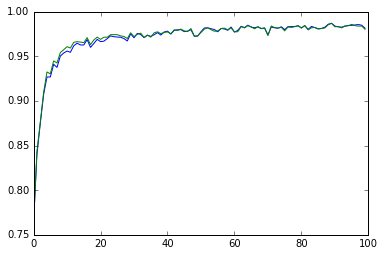

In [71]:
train_acc = [h['train_acc'] for h in history]
test_acc = [h['valid_acc'] for h in history]
plt.plot(train_acc)
plt.plot(test_acc)

In [72]:
test_acc = acc_fn(test.X, test.y)
print(1-test_acc)

0.0188


(<lasagne.layers.input.InputLayer object at 0x7ff6fdf5b950>, (50000, 1, 28, 28))


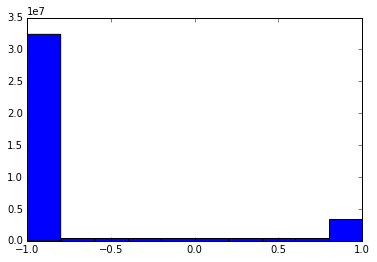

(<lasagne.layers.dense.DenseLayer object at 0x7ff6fdf5b910>, (50000, 1000))


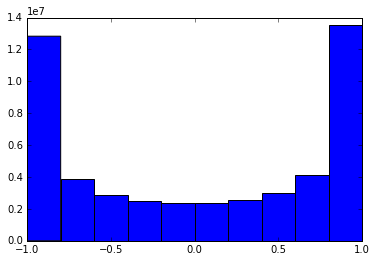

KeyboardInterrupt: 

In [73]:
all_layers = layers.get_all_layers(net)
input_var = all_layers[0].input_var
for l in all_layers:
    f = theano.function([input_var], layers.get_output(l, input_var))
    h = f(train.X)
    print(l, h.shape)
    plt.hist(h.flatten())
    plt.show()